## Контрольная работа
### Game of life
### Жерноклеев Дмитрий

## Реализация Игры "Жизнь" Конвэя, построенная в агентной среде с дискретным временем, дискретным пространством и моделью соседства Мура. Игра проводится на разбитом на клетки поле. У каждой клетки есть восемь соседей (граничащие клетки). Клетка может быть живой или мертвой. Она гибнет, если ее окрестность перенаселена (более $3$-х клеток) или пустынна (менее $2$-х клеток); клетка выживает, если число соседей равно $2$ или $3$; клетка рождается, если число соседей равно $3$. Агенты в этой модели могут рассматриваться как клеточные автоматы.

### Задание
Реализовать дополнительно следующую логику:

1. Сделать начальную пропорцию живых клеток не константой, а параметром модели.
2. Если клетка жива на протяжении $k$ шагов, то на следующем шаге она умирает без относительно исходного алгоритма ($k$ – параметр).
3. Каждые $m$ шагов "оживают" $n$ случайно выбранных клеток ($m$, $n$ – параметры).

Вывести график количества живых клеток по времени, а также вычислить математическое ожидание и дисперсию числа живых клеток на 50-м шаге моделирования при варьировании параметрами $k$ от $3$ до $5$, $m$ от $2$ до $5$ и $n$ от $1$ до $5$.

In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
from mesa import Model, Agent
from mesa.visualization.modules import CanvasGrid
from mesa.time import SimultaneousActivation
from mesa.space import Grid
from mesa.visualization.ModularVisualization import ModularServer

In [3]:
from mesa.datacollection import DataCollector
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

## Модель Игра Жизнь

### Инициализация стартовой модели

In [4]:
class Cell(Agent):
    """Represents a single ALIVE or DEAD cell in the simulation."""

    DEAD = 0
    ALIVE = 1

    def __init__(self, pos, model, init_state=DEAD):
        """
        Create a cell, in the given state, at the given x, y position.
        """
        super().__init__(pos, model)
        self.x, self.y = pos
        self.state = init_state
        self._nextState = None
        self.lifetime = 0 # длительность жизни клетки в шагах

    @property
    def isAlive(self):
        return self.state == self.ALIVE

    @property
    def neighbors(self):
        return self.model.grid.neighbor_iter((self.x, self.y), True)

    def step(self):
        """
        Compute if the cell will be dead or alive at the next tick.  This is
        based on the number of alive or dead neighbors.  The state is not
        changed here, but is just computed and stored in self._nextState,
        because our current state may still be necessary for our neighbors
        to calculate their next state.
        """

        # Get the neighbors and apply the rules on whether to be alive or dead
        # at the next tick.
        live_neighbors = sum(neighbor.isAlive for neighbor in self.neighbors)

        # Assume nextState is unchanged, unless changed below.
        self._nextState = self.state
        if self.isAlive:
            if live_neighbors < 2 or live_neighbors > 3:
                self._nextState = self.DEAD
                self.lifetime = 0 # зануляем длительность жизни после смерти
            elif self.lifetime == (self.model.k - 1): # условие на длительность жизни
                self._nextState = self.DEAD # если выполняется, клетка также умирает
                self.lifetime = 0
            else:
                self.lifetime += 1 # продолжает жить => увеличиваем "возраст"
        else:
            if live_neighbors == 3:
                self._nextState = self.ALIVE

    def advance(self):
        """
        Set the state to the new computed state -- computed in step().
        """
        self.state = self._nextState

In [5]:
def alive_count(model): # функция для подсчета числа живых клеток
    states_list = [i.state for i in model.grid]
    return sum(states_list)

In [6]:
class ConwaysGameOfLife(Model):
    """
    Represents the 2-dimensional array of cells in Conway's
    Game of Life.
    """
    
    def __init__(self, height=50, width=50, alive_proportion=0.1, k=4, m=4, n=3):
        """
        Create a new playing area of (height, width) cells.
        """

        # Set up the grid and schedule.

        # Use SimultaneousActivation which simulates all the cells
        # computing their next state simultaneously.  This needs to
        # be done because each cell's next state depends on the current
        # state of all its neighbors -- before they've changed.
        self.schedule = SimultaneousActivation(self)

        # Use a simple grid, where edges wrap around.
        self.grid = Grid(height, width, torus=True)
        
        buf_grid = np.zeros((height, width), int) # вспомогательный "грид" из нулей,
                                                  # на который кидаем случайно 1 в соответствии 
                                                  # с заданной пропорцией живых клеток
        choices = np.random.choice(buf_grid.size, 
                                   int(height * width * alive_proportion), replace=False)
        buf_grid.ravel()[choices] = 1 
        # print(buf_grid)
        self.height = height
        self.width = width
        self.k = k # параметры, требуемые по заданию
        self.m = m
        self.n = n
        self.cur_step_num = 0 # номер текущего шага

        # Place a cell at each location, with some initialized to
        # ALIVE and some to DEAD.
        for (contents, x, y) in self.grid.coord_iter():
            cell = Cell((x, y), self)
            # if self.random.random() < alive_proportion: # более "простая" реализация
            #    cell.state = cell.ALIVE
            if buf_grid[x, y] == 1: # 1 в соответствующей ячейке => объявляем живой
                cell.state = cell.ALIVE
            self.grid.place_agent(cell, (x, y))
            self.schedule.add(cell)

        self.running = True
        
        self.datacollector = DataCollector(
            model_reporters={"Alive_count": alive_count}) # для сбора данных по прогону модели

    def step(self):
        """
        Have the scheduler advance each cell by one step
        """
        self.datacollector.collect(self)
        self.schedule.step()
        self.cur_step_num += 1
        if self.cur_step_num % self.m == 0 and self.cur_step_num > 0:
            cnt = 0
            while True: # оживляем каждые m шагов n случайных клеток
                x_rand = np.random.randint(0, self.height)
                y_rand = np.random.randint(0, self.width)
                rand_pos = (x_rand, y_rand)
                if len(self.grid.get_cell_list_contents([rand_pos])) == 1:
                    rand_cell = self.grid.get_cell_list_contents([rand_pos]).pop()
                    if rand_cell.state == rand_cell.DEAD: # проверяем, мертвая ли та,
                        rand_cell.state = rand_cell.ALIVE # которую хотим оживить
                        cnt += 1
                else:
                    print('some trouble')
                if cnt == self.n:
                    break        

In [19]:
model = ConwaysGameOfLife(height=50, width=50, alive_proportion=0.1, k=4, m=4, n=3)
for i in range(50):
    model.step()

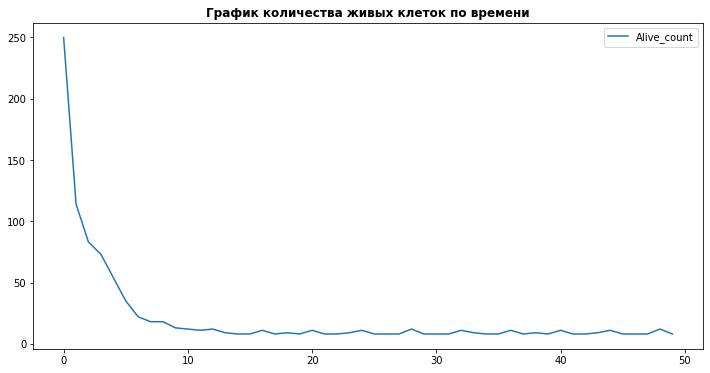

In [20]:
alive_amount = model.datacollector.get_model_vars_dataframe()
alive_amount.plot(figsize=(12, 6))
plt.title('График количества живых клеток по времени', weight='bold')
plt.show()

In [21]:
alive_amount.tail(10)

,Alive_count
40,11
41,8
42,8
43,9
44,11
45,8
46,8
47,8
48,12
49,8


In [22]:
df_cyc = alive_amount.copy()
for j in range(30):
    model_cyc = ConwaysGameOfLife(height=50, width=50, alive_proportion=0.1, k=4, m=4, n=3) 
    for i in range(50):
        model_cyc.step()
    alive_amount_cyc = model_cyc.datacollector.get_model_vars_dataframe()
    df_cyc['Alive_count' + str(j)] = alive_amount_cyc['Alive_count']

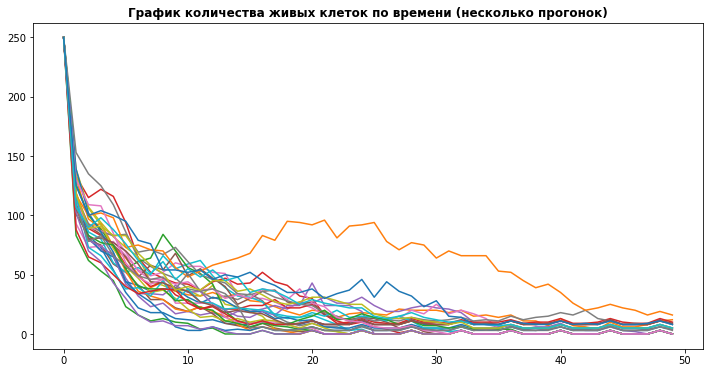

In [23]:
df_cyc.plot(legend=False, figsize=(12, 6))
plt.title('График количества живых клеток по времени (несколько прогонок)', weight='bold')
plt.show()

In [24]:
# Вычислим мат. ожидание и дисперсию числа живых клеток на 50-м шаге моделирования при варьировании параметрами, 
# выполняя по одной прогонке для каждого набора параметров
# stat_df = pd.DataFrame(columns=['k', 'm', 'n', 'alive_amount'])
# k_lst = [i for i in range(3, 6)] # k от 3 до 5, m от 2 до 5 и n от 1 до 5
# m_lst = [i for i in range(2, 6)] 
# n_lst = [i for i in range(1, 6)]

# lists = [k_lst, m_lst, n_lst]
# prod_list = itertools.product(*lists)
# for el in prod_list: # варьируем параметры
#     k, m, n = el
#     model_run = ConwaysGameOfLife(height=50, width=50, alive_proportion=0.1, k=k, m=m, n=n)
#     for i in range(50):
#         model_run.step()
#     alive_amount_run = model_run.datacollector.get_model_vars_dataframe()
#     alive_amount_run_val = alive_amount_run['Alive_count'].iloc[-1]
#     d = {'k': k, 'm': m, 'n': n, 
#          'alive_amount': alive_amount_run_val} # после прогонки модели
#     stat_df = stat_df.append(d, ignore_index=True) # добавляем полученное значение 
#                                               # кол-ва живых клеток на 50-м шаге в датафрейм 
# print('''Мат. ожидание числа живых клеток на 50-м шаге при варьировании параметров = {0:.2f} 
# Дисперсия числа живых клеток на 50-м шаге при варьировании параметров = {1:.2f}'''.format(
#     stat_df['alive_amount'].mean(), stat_df['alive_amount'].var()))
# stat_df

Вычислим мат. ожидание и дисперсию числа живых клеток на 50-м шаге моделирования при варьировании параметрами, выполняя мультистарт для каждого набора параметров

In [7]:
k_lst = [i for i in range(3, 6)] # k от 3 до 5, m от 2 до 5 и n от 1 до 5
m_lst = [i for i in range(2, 6)] 
n_lst = [i for i in range(1, 6)]

lists = [k_lst, m_lst, n_lst]
prod_list = itertools.product(*lists)

idx = pd.MultiIndex.from_tuples((), names=('(k, m, n)', 'RunNum'))
multi_df = pd.DataFrame(index=idx, columns=['alive_amount'])

In [8]:
for el in prod_list: # варьируем параметры
    k, m, n = el
    for j in range(120):
        model_run = ConwaysGameOfLife(height=50, width=50, alive_proportion=0.1, k=k, m=m, n=n)
        for i in range(50):
            model_run.step()
        alive_amount_run = model_run.datacollector.get_model_vars_dataframe()
        multi_df.loc[((k, m, n), j), :] = alive_amount_run['Alive_count'].iloc[-1]

In [9]:
print('''Мат. ожидание числа живых клеток на 50-м шаге при варьировании параметров = {0:.2f} 
Дисперсия числа живых клеток на 50-м шаге при варьировании параметров = {1:.2f}'''.format(
    multi_df['alive_amount'].mean(), multi_df['alive_amount'].var()))

Мат. ожидание числа живых клеток на 50-м шаге при варьировании параметров = 4.88 
Дисперсия числа живых клеток на 50-м шаге при варьировании параметров = 102.93


Теперь подсчитаем статистики не по всей выборке, а отдельно по каждому набору параметров.

In [10]:
mean_std_df = multi_df.groupby('(k, m, n)')['alive_amount'].agg(['mean', 'var', 'std']) 
mean_std_df.rename(columns={'mean': 'Мат. ожидание', 'var': 'Дисперсия', 'std': 'Станд. откл.'}, inplace=True)
mean_std_df.index.names = ['Набор параметров']
mean_std_df

,Мат. ожидание,Дисперсия,Станд. откл.
Набор параметров,,,
"(3, 2, 1)",0.625000,1.950630,1.396650
"(3, 2, 2)",0.500000,1.260504,1.122722
"(3, 2, 3)",0.716667,3.398039,1.843377
"(3, 2, 4)",0.491667,1.478922,1.216109
"(3, 2, 5)",0.250000,1.466387,1.210944
"(3, 3, 1)",0.791667,2.199930,1.483216
"(3, 3, 2)",0.783333,3.297199,1.815819
"(3, 3, 3)",0.808333,3.030182,1.740742
"(3, 3, 4)",0.350000,1.086555,1.042379


Определим, проведено ли достаточное число экспериментов (стартов) по алгоритму, описанному в  
https://cyberleninka.ru/article/n/tochnyy-metod-rascheta-neobhodimogo-kolichestva-povtornyh-opytov/viewer

In [13]:
mean_std_df['Мат. ожидание'] * 0.15 / mean_std_df['Станд. откл.']

Набор параметров
(3, 2, 1)    0.067125
(3, 2, 2)    0.066802
(3, 2, 3)    0.058317
(3, 2, 4)    0.060644
(3, 2, 5)    0.030968
(3, 3, 1)    0.080063
(3, 3, 2)    0.064709
(3, 3, 3)    0.069654
(3, 3, 4)    0.050366
(3, 3, 5)    0.058589
(3, 4, 1)    0.067826
(3, 4, 2)    0.058871
(3, 4, 3)    0.061211
(3, 4, 4)    0.070585
(3, 4, 5)    0.057120
(3, 5, 1)    0.071822
(3, 5, 2)    0.070953
(3, 5, 3)    0.064029
(3, 5, 4)    0.060031
(3, 5, 5)    0.060685
(4, 2, 1)    0.092880
(4, 2, 2)    0.084652
(4, 2, 3)    0.080200
(4, 2, 4)    0.083267
(4, 2, 5)    0.088116
(4, 3, 1)    0.088752
(4, 3, 2)    0.092350
(4, 3, 3)    0.105182
(4, 3, 4)    0.092462
(4, 3, 5)    0.072067
(4, 4, 1)    0.087348
(4, 4, 2)    0.097577
(4, 4, 3)    0.085075
(4, 4, 4)    0.085113
(4, 4, 5)    0.089650
(4, 5, 1)    0.087431
(4, 5, 2)    0.093209
(4, 5, 3)    0.083425
(4, 5, 4)    0.084343
(4, 5, 5)    0.084066
(5, 2, 1)    0.118714
(5, 2, 2)    0.110568
(5, 2, 3)    0.114774
(5, 2, 4)    0.107136
(5, 2, 5)    0.

Повторяя ту же процедуру, что и для 40 прогонок, делаем вывод, что 120 так же недостаточно. Времени для ещё одного рестарта и выполнения кода с, видимо, количеством прогонок на один набор, превышающим 200, у меня явно не хватит (по моим подсчетам на моем компьютере это будет исполняться около 2,5 - 3 часов, и не факт, что даже этого количества будет хватать для получения статистически достоверных результатов. Учитывая все выше сказанное, в качестве результатов оставим значения статистик, полученные выше. Дальнейшая "калибровка" требует просто увеличения числа прогонок на один набор параметров и времени.

**Для 40 прогонок (изначальный результат, пояснение в записке):**

In [37]:
mean_std_df['Мат. ожидание'] * 0.15 / mean_std_df['Станд. откл.']

Набор параметров
(3, 2, 1)    0.063621
(3, 2, 2)    0.064642
(3, 2, 3)    0.033979
(3, 2, 4)    0.064642
(3, 2, 5)    0.053192
(3, 3, 1)    0.070354
(3, 3, 2)    0.074057
(3, 3, 3)    0.058848
(3, 3, 4)    0.062220
(3, 3, 5)    0.068216
(3, 4, 1)    0.068216
(3, 4, 2)    0.074057
(3, 4, 3)    0.032793
(3, 4, 4)    0.085513
(3, 4, 5)    0.042175
(3, 5, 1)    0.064642
(3, 5, 2)    0.052733
(3, 5, 3)    0.042175
(3, 5, 4)    0.074057
(3, 5, 5)    0.064506
(4, 2, 1)    0.101343
(4, 2, 2)    0.074627
(4, 2, 3)    0.091182
(4, 2, 4)    0.060312
(4, 2, 5)    0.083176
(4, 3, 1)    0.082347
(4, 3, 2)    0.117274
(4, 3, 3)    0.093714
(4, 3, 4)    0.086061
(4, 3, 5)    0.102825
(4, 4, 1)    0.071367
(4, 4, 2)    0.060179
(4, 4, 3)    0.086341
(4, 4, 4)    0.084326
(4, 4, 5)    0.072844
(4, 5, 1)    0.081836
(4, 5, 2)    0.088551
(4, 5, 3)    0.103017
(4, 5, 4)    0.084764
(4, 5, 5)    0.130108
(5, 2, 1)    0.115369
(5, 2, 2)    0.138352
(5, 2, 3)    0.091872
(5, 2, 4)    0.106557
(5, 2, 5)    0.

Находим по таблице t-критерия Стьюдента из статьи ближайшее меньшее относительно расчетного табличное значение. Для доверительной вероятности 0.95 для всех наборов параметров оно превышает 100 (ближайшее меньшее даже не указано в таблице), соответственно, т.к. ранее проведено 40 прогонок для каждого набора, необходимо дополнительно произвести минимум 60 прогонок для каждого.

In [6]:
def portrayCell(cell):
    """
    This function is registered with the visualization server to be called
    each tick to indicate how to draw the cell in its current state.
    :param cell:  the cell in the simulation
    :return: the portrayal dictionary.
    """
    assert cell is not None
    return {
        "Shape": "rect",
        "w": 1,
        "h": 1,
        "Filled": "true",
        "Layer": 0,
        "x": cell.x,
        "y": cell.y,
        "Color": "black" if cell.isAlive else "white",
    }

In [7]:
# Make a world that is 50x50, on a 250x250 display.
canvas_element = CanvasGrid(portrayCell, 50, 50, 250, 250)

server = ModularServer(
    ConwaysGameOfLife, [canvas_element], "Game of Life", {"height": 50, "width": 50}
)

In [ ]:
server.port = 8523
server.launch()